In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from utilties.imports import *

In [3]:
#typical example setup
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
x_train, y_train, x_valid, y_valid = get_data(MNIST_URL)
number_hidden = 50
batch_size = 64
num_categories = y_train.max().item()+1
loss_function = F.cross_entropy
training_ds = Dataset(x_train, y_train)
validation_ds = Dataset(x_valid, y_valid)
train_dl = DataLoader(training_ds, batch_size, shuffle = True) #random sampler
valid_dl = DataLoader(validation_ds, batch_size*2, shuffle = False) #sequential sampler
model, optimizer = get_model(train_dl)

### Adding Exceptions to Callback control Throw

#### C++ and C Developers
![screaming](https://media.giphy.com/media/KmTnUKop0AfFm/giphy.gif "screaming")

### Moving __call__ into Callback()
- moving the call functionality into the callback class itself, from the Runner Class
- allows for more verastile (injectable) behavior per callback

In [4]:
class Callback():
    _order = 0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False
    
#our standard used callback, included in every model
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

#### New Exceptions : Extend Regular Old Python Exceptions

In [5]:
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

### The New Runner class
- Try Catch Blocks set the Control Flow
- New Control Flow Callbacks are called __after__ Catching its Exception Class

In [6]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = convert_to_list(cbs)
        for cbf in convert_to_list(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs


    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_function(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, mod, optimizer, loss_func, train_dl, valid_dl):
        self.epochs = epochs
        self.loss = tensor(0.)
        self.model = mod
        self.opt = optimizer
        self.loss_function = loss_func
        self.valid_dl = valid_dl
        self.train_dl = train_dl
        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        return_val = False
        for cb in sorted(self.cbs, key=lambda x: x._order): return_val = cb(cb_name) or return_val
        return return_val

In [7]:
#testing the new control flow, refactored TestCallback
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10: raise CancelTrainException()

In [8]:
runner = Runner(cb_funcs=TestCallback)
runner.fit(3, model, optimizer, loss_function, train_dl, valid_dl)

0
1
2
3
4
5
6
7
8
9
10


In [9]:
### Refactoring the rest of the callbacks to the new form

In [10]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

## Creating a Learning Rate Finder

In [11]:
class LR_Finder(Callback): #to-do add exponential smoothing to loss
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9

    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr

    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [12]:
runner = Runner(cb_funcs=[LR_Finder, Recorder])
runner.fit(2, model, optimizer, loss_function, train_dl, valid_dl)

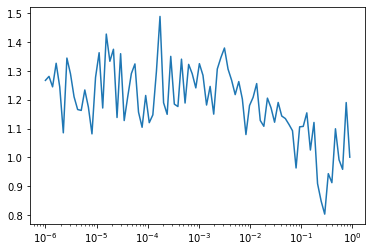

In [13]:
runner.recorder.plot(skip_last=5)

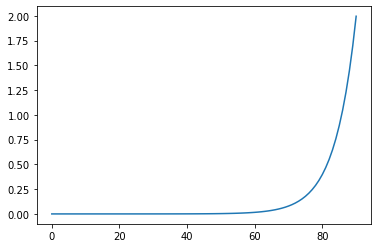

In [14]:
runner.recorder.plot_lr()